In [1]:
#System
import sys
import os

#Api SRC
import tweepy
sys.path.insert(1, '../')
import keys

#text
from datetime import datetime
import string
from collections import Counter
from unidecode import unidecode #
import re

#visual
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pyLDAvis.gensim #
from mpl_toolkits import mplot3d

#ml
import gensim
import pickle #
import nltk

#skl
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import MDS

from scipy.cluster.hierarchy import ward, dendrogram
#math
import random
import math

import pandas as pd

%matplotlib inline

/home/albrigs/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/home/albrigs/anaconda3/lib/python3.7/site-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Mapping
/home/albrigs/anaconda3/lib/python3.7/site-packages/botocore/awsrequest.py:624: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  class HeadersDict(collections.MutableMapping):
/home/albrigs/anaconda3/lib/python3.7/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.spar

In [2]:
#api conf
auth = tweepy.OAuthHandler(keys.cos_pub, keys.cos_sec)
auth.set_access_token(keys.as_pub, keys.as_sec)

api = tweepy.API(auth) 
data_folder = '../data/'

In [3]:
#getting data
#TODO criar um gerador de termos de pesquisa
search_terms = [
    'lula',
    'presidente',
    'bolsonaro',
    'lulalivre',
    'stf',
    'vergonha nacional',
    'sergio moro',
    'pt',
    'brasil',
    'bolsominion',
    'segunda instância',
    'pec 410/18',
    'lava jato',
    'intercept',
    'vaza jato'
]
def twitter_search(terms):
    tmp_search_result = []
 
    for e in terms:
        partial_result = [];
        #API limita o acesso aos 100 ultimos tweets de uma pesquisa usando licensa não comercial
        api_result = api.search(q=e, tweet_mode='extended', count=100, lang='pt', retweeted=False, reply=False)

        for prop in api_result:
            partial_result.append(prop._json['full_text'])
        tmp_search_result.extend(partial_result)
        
    return tmp_search_result
search_result = set(twitter_search(search_terms)) # removendo tweets duplicados
search_result

{'"Na #Bolivia, um golpe de estado foi consumado como resultado das ações conjuntas de civis violentos, pessoal policial aquartelado e a passividade do exército. É um golpe perpetrado contra o presidente @evoespueblo, que tinha convocado um novo processo eleitoral".\n@alferdez https://t.co/K6af7lXpyD',
 '#ImpeachmentGilmarMendes\n@STF\nVERGONHA NACIONAL. https://t.co/c6ugwbku0P',
 '#ImpeachmentGilmarMendes\nVergonha Nacional! Basta de soltar bandidos!',
 '#ImpeachmentGilmarMendes e DIAS TOFFOLI Vergonha Nacional https://t.co/7fLp593POK',
 '#ImpeachmentGilmarMendes e Dias Toffoli Vergonha Nacional https://t.co/uTqXuGokp5',
 '#ImpeachmentGilmarMendes nada! Quero ver esse verme e sua esposa cúmplice na cadeia! @STF_oficial vergonha nacional!',
 '#LulaLivre por favor, amooooooooooooo\nDesculpa é que eu sou gay',
 '#Prisao2aInstanciaSim . Faltam só 6 senadores para ter os  votos necessários para pec 410/18. Vamos lá senadores do Brasil !!!!! Lutem pelo seu País!!!!!🇧🇷🇧🇷🇧🇷 https://t.co/uCER2

In [11]:
#saving data in a txt file

data_path = '{0}{1}/'.format(data_folder, datetime.now(tz=None))
graphics_path = data_path +'graphics/' 

os.makedirs(graphics_path)

#raw file
with open(data_path+'raw.txt', 'wb') as file:
    for e in search_result:
        entry = '\n'+' '.join(e.splitlines())
        file.write(entry.encode())
    file.close()
    
#search terms
with open(data_path+'search_terms.txt', 'wb') as file:
    entry = ' '.join(search_terms)
    file.write(entry.encode())
    file.close()

In [13]:
#filtrando texto
def filter_text(txt):
    # juntando todas as sentenças e removendo \n
    text = ''.join(''.join(txt).splitlines())
    text = text.rstrip()
    text = unidecode(text)
    
    #nltk.download('stopwords')
    stop_words = nltk.corpus.stopwords.words('portuguese')
    stop_words.extend(['', 'rt', 'nao', 'pra', 'q']) #tirando espaços vazios e marcas de retweet
    
    w_list = []
    w_list = text.split(' ')
    w_list = [e.strip().strip(string.punctuation).lower() for e in w_list]
    w_list = filter(None, w_list)
    w_list = [e for e in w_list if "https" not in e and e[0] !=  '@'] #tirando  links e menções  
    
    w_filtered = ' '.join(w_list)
    
    #removendo caracteres não alfanuméricos de dentro da string e stop_words
    w_list = [e for e in re.sub('[^A-Za-z0-9]+', ' ', w_filtered).split(' ') if e not in stop_words ]
    w_filtered = ' '.join(w_list) #atualizando texto filtrado

    return {
        'text': w_filtered,
        'list': w_list
    }
text = filter_text(search_result)

words_list = text['list']
filtered_words = text['text']

print('List:\n{0}\n\nWords:'.format(words_list[:40]))
print(filtered_words[:200])

List:
['bom', 'dia', 'proletariado', 'sulamericano', 'dorme', 'onda', 'progressista', 'america', 'latina', 'acorda', 'golpe', 'militar', 'bolivia', 'reformismo', 'beco', 'saida', 'conciliacao', 'so', 'rabo', 'leiam', 'marx', 'organizem', 'bebam', 'agua', 'boa', 'pa', 'nois', 'golpeenbolivia', 'lulalivre', 'brazilfight', 'vai', 'humilhar', 'stf', 'pois', 'todos', 'membros', 'sao', 'funcionarios', 'particulares', 'lacaios']

Words:
bom dia proletariado sulamericano dorme onda progressista america latina acorda golpe militar bolivia reformismo beco saida conciliacao so rabo leiam marx organizem bebam agua boa pa nois golpeenboliv


In [14]:
filtered_sentenses = []
for e in search_result:
    filtered_sentenses.append(filter_text(e)['list'])
    
#filtered tweets
with open(data_path+'filtered_tweets.txt', 'wb') as file:
    tmpTxt = ''
    for e in filtered_sentenses:
        tmpTxt = tmpTxt + ' '.join(e) + '\n'
        
    file.write(tmpTxt.encode())
    file.close()    

print(filtered_sentenses)

[['bom', 'dia', 'proletariado', 'sulamericano', 'dorme', 'onda', 'progressista', 'america', 'latina', 'acorda', 'golpe', 'militar', 'bolivia', 'reformismo', 'beco', 'saida', 'conciliacao', 'so', 'rabo', 'leiam', 'marx', 'organizem', 'bebam', 'agua', 'boa', 'pa', 'nois', 'golpeenbolivia', 'lulalivre'], ['brazilfight', 'vai', 'humilhar', 'stf', 'pois', 'todos', 'membros', 'sao', 'funcionarios', 'particulares', 'lacaios', 'comprados', 'peso', 'ouro', 'tudo', 'acontece', 'la', 'tudo', 'ensaiado', 'combinado', 'antes', 'voce', 'vota', 'assim', 'outro', 'vota', 'assado', 'assim', 'diante', 'artigo142'], ['josiasteofilo', 'lula', 'politicos', 'individuos', 'cinicos', 'corruptos', 'mundo', 'steve', 'bannon'], ['125', 'dias', 'dnaworldtour', 'brasil', 'backstreetboys', 'ktbspa'], ['deputadofederal', 'lava', 'jato', 'moro', 'usaram', 'dinheiro', 'contribuinte', 'brasileiro', 'estrutura', 'estado', 'interferir', 'vida', 'interna'], ['themingau', 'fala', 'lula', 'ultimamente', 'resolvi', 'falar', 

In [15]:
#termos mais frequentes
frequence_list= []
frequence_list = Counter(words_list)

frequence_list.most_common(20)

[('lula', 114),
 ('stf', 107),
 ('brasil', 83),
 ('moro', 79),
 ('bolsonaro', 79),
 ('presidente', 72),
 ('pec', 70),
 ('prisao', 59),
 ('instancia', 58),
 ('ser', 55),
 ('jato', 54),
 ('segunda', 53),
 ('410', 47),
 ('18', 47),
 ('sergio', 45),
 ('lulalivre', 44),
 ('pt', 44),
 ('golpe', 43),
 ('lava', 42),
 ('ja', 41)]

In [16]:
word_cloud = WordCloud(max_font_size=50).generate(filtered_words)

with open(data_path+'filtered_words_soup.txt', "wb") as file:
    file.write(filtered_words.encode())
    file.close()

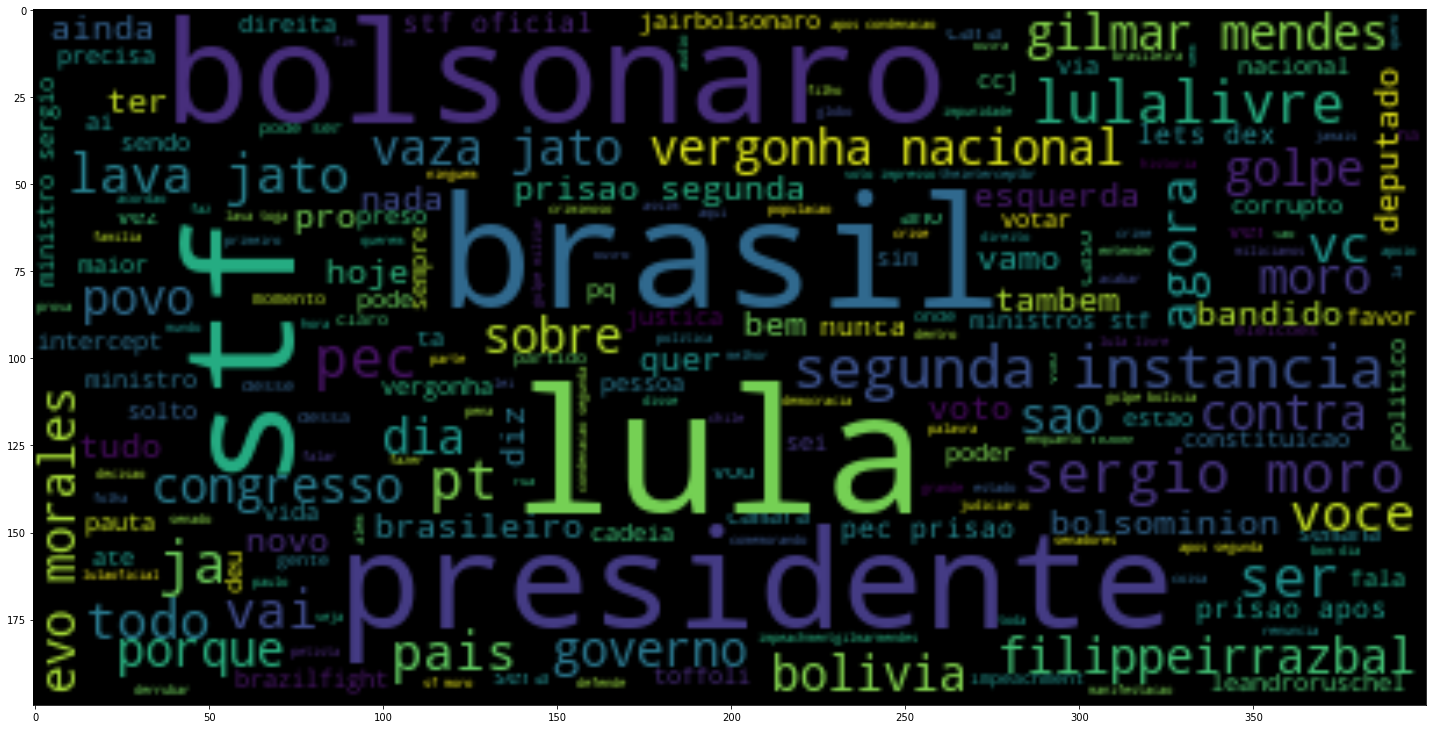

In [17]:
fig, ax = plt.subplots(figsize=(20,20))
ax.imshow(word_cloud, interpolation='bilinear')
plt.axis(label= 'Nearest')
plt.tight_layout()
plt.savefig(graphics_path+'w_c_near.png', dpi=90)
plt.show()

In [18]:
#algoritmo que mostra vizinhos
expression = "politica"

positions = [] #localização onde a plavra se encontra
for i, e in enumerate(words_list):
    if expression == e:
        positions.append(i)

print(len(positions))
print(positions)

6
[398, 1513, 3150, 3289, 6892, 7888]


In [19]:
neighbors = 2
for e in positions[0:30]:
    print(words_list[e-neighbors : e+neighbors+1])

['moro', 'conexao', 'politica', 'leoarlac', 'dou']
['flagrante', 'intervencao', 'politica', 'ignorar', 'vaza']
['armadas', 'metem', 'politica', 'prendem', 'presidente']
['avenida', 'paulista', 'politica', 'estadao', 'marcelopintoba']
['centro', 'vida', 'politica', 'brasileira', 'agora']
['favor', 'quadrilha', 'politica', 'destruiu', 'pais']


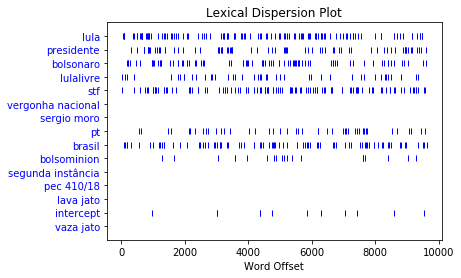

In [20]:
tknzr = nltk.tokenize.WordPunctTokenizer()
tokens = tknzr.tokenize(filtered_words)
nltk_text = nltk.Text(tokens)

nltk_text.dispersion_plot(search_terms)

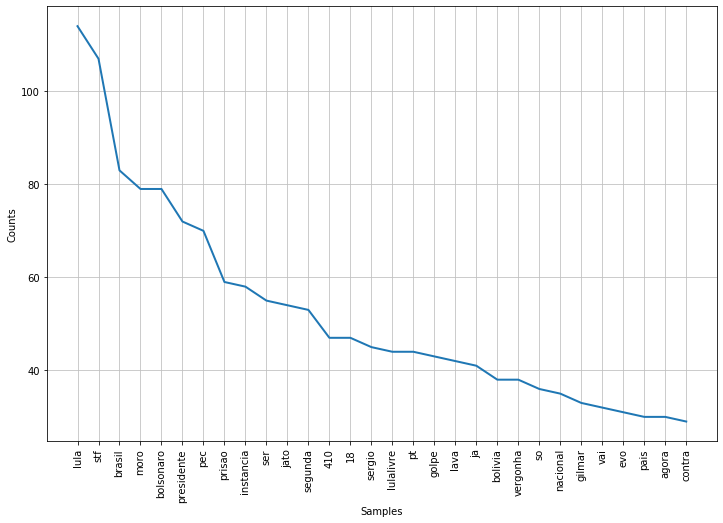

In [21]:
fd_words = nltk.FreqDist(tokens)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12,8)) 
fd_words.plot(30)

In [22]:
#bag of words
corpus_path = data_path+'corpus.pkl'
dict_path = data_path+'dictionary.gensim'

dictionary = gensim.corpora.Dictionary(filtered_sentenses)
corpus = [dictionary.doc2bow(e) for e in filtered_sentenses]

#generating dict
pickle.dump(corpus, open( corpus_path, 'wb'))
dictionary.save(dict_path)

In [23]:
n_topics = 11 #número de tópicos
n_words = 5 #número de palavras relacionadas
lda_model_path = data_path+'my_cur_model_{0}t_{1}.gensim'.format(str(n_topics), str(n_words))

lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics = n_topics, id2word=dictionary, passes=15)
lda_model.save(lda_model_path)
topics = lda_model.print_topics(num_words= n_words) #palaras por array
for e in topics:
    print(str(e)+'\n')

(0, '0.017*"stf" + 0.010*"presidente" + 0.008*"prisao" + 0.007*"bolivia" + 0.007*"golpe"')

(1, '0.016*"brasil" + 0.007*"segunda" + 0.007*"bolsonaro" + 0.007*"instancia" + 0.006*"prisao"')

(2, '0.014*"stf" + 0.012*"pec" + 0.011*"jato" + 0.010*"18" + 0.010*"410"')

(3, '0.021*"vergonha" + 0.021*"nacional" + 0.013*"evo" + 0.012*"stf" + 0.012*"impeachmentgilmarmendes"')

(4, '0.018*"lula" + 0.009*"bolsonaro" + 0.007*"presidente" + 0.005*"lulalivre" + 0.005*"segunda"')

(5, '0.024*"lula" + 0.012*"brasil" + 0.009*"lulalivre" + 0.008*"ser" + 0.006*"presidente"')

(6, '0.009*"pec" + 0.009*"bolsonaro" + 0.008*"bolsominion" + 0.008*"lula" + 0.007*"18"')

(7, '0.009*"presidente" + 0.007*"moro" + 0.007*"lula" + 0.006*"bolsonaro" + 0.006*"ser"')

(8, '0.014*"moro" + 0.010*"pec" + 0.008*"lula" + 0.008*"presidente" + 0.008*"sergio"')

(9, '0.016*"stf" + 0.013*"moro" + 0.010*"sergio" + 0.009*"jato" + 0.008*"pt"')

(10, '0.009*"voces" + 0.008*"moro" + 0.007*"esquerda" + 0.007*"pt" + 0.007*"gilmar"')


In [24]:
#manter as duas tarefas de visualização das relações entre tópicos e palavras separadas, pois são tarefas demoradas
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)

/home/albrigs/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [25]:
pyLDAvis.display(lda_display)

In [26]:
print(search_terms)

['vaza jato', 'intercept', 'lava jato', 'pec 410/18', 'segunda instância', 'bolsominion', 'brasil', 'pt', 'sergio moro', 'vergonha nacional', 'stf', 'lulalivre', 'bolsonaro', 'presidente', 'lula']


In [27]:
print(data_path)

../data/2019-11-11 09:38:45.985811/


In [28]:
#clusterização
tf_idf_vec = TfidfVectorizer()
content_tf_idf = tf_idf_vec.fit_transform(words_list)
print(content_tf_idf)

  (0, 531)	1.0
  (1, 1209)	1.0
  (2, 3154)	1.0
  (3, 3660)	1.0
  (4, 1271)	1.0
  (5, 2765)	1.0
  (6, 3150)	1.0
  (7, 246)	1.0
  (8, 2202)	1.0
  (9, 120)	1.0
  (10, 1799)	1.0
  (11, 2528)	1.0
  (12, 519)	1.0
  (13, 3314)	1.0
  (14, 479)	1.0
  (15, 3470)	1.0
  (16, 839)	1.0
  (17, 3595)	1.0
  (18, 3255)	1.0
  (19, 2223)	1.0
  (20, 2430)	1.0
  (21, 2794)	1.0
  (22, 475)	1.0
  (23, 175)	1.0
  (24, 511)	1.0
  :	:
  (9591, 770)	1.0
  (9592, 3753)	1.0
  (9593, 1215)	1.0
  (9594, 527)	1.0
  (9595, 680)	1.0
  (9596, 3221)	1.0
  (9597, 151)	1.0
  (9598, 986)	1.0
  (9599, 2509)	1.0
  (9600, 1539)	1.0
  (9601, 3221)	1.0
  (9602, 3894)	1.0
  (9603, 242)	1.0
  (9604, 681)	1.0
  (9605, 2508)	1.0
  (9606, 2401)	1.0
  (9607, 1505)	1.0
  (9608, 3101)	1.0
  (9609, 3665)	1.0
  (9610, 3810)	1.0
  (9611, 1321)	1.0
  (9612, 519)	1.0
  (9613, 2584)	1.0
  (9614, 547)	1.0
  (9615, 3235)	1.0


In [29]:
#vetorizando para passar por clusterização
tfidf_vectorizer = TfidfVectorizer(
    use_idf=True 
)
sentenses = [' '.join(e) for e in filtered_sentenses]
tfidf_matrix = tfidf_vectorizer.fit_transform(sentenses)
print(tfidf_matrix.shape)
terms = tfidf_vectorizer.get_feature_names()
print(terms)

(725, 4001)
['01', '017', '02', '05', '08', '09', '10', '100', '101', '11', '111', '125', '13', '142', '15', '150', '16', '17', '18', '18e', '19', '1a', '2009', '2011', '2012', '2013', '2015', '2016', '2017', '2018', '2019', '2020', '2022', '2023', '2026', '22', '26', '2a', '2deg', '2o', '30', '300', '320', '33', '39', '3de7', '40', '400', '410', '50', '500', '57', '5o', '60', '67', '70', '705', '87', '88', '89', '90', 'abaixo', 'abala', 'abalados', 'abandonar', 'abdel', 'abencoa', 'aberta', 'abertamente', 'abertos', 'aborto', 'abouanni', 'abracar', 'abraco', 'abrahamweint', 'abre', 'abril', 'abriu', 'abs', 'absurdo', 'abuso', 'abusos', 'ac', 'acabar', 'acabarem', 'acabaria', 'acabou', 'acacionst', 'academia', 'acalmar', 'acampamentos', 'acao', 'acaso', 'acefalos', 'aceitam', 'aceitar', 'aceitou', 'aceleracao', 'acertou', 'acesso', 'acha', 'acham', 'achando', 'acharam', 'achas', 'acho', 'achou', 'acidadeplantao', 'acima', 'acionar', 'aclachaitis', 'acoes', 'acompanhando', 'acompanhava'

In [30]:
#calculando quantidade ideal de clusters
wcss = []
for n in range(2, 21):
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(X=tfidf_matrix)
    wcss.append(kmeans.inertia_)

x1, y1 = 2, wcss[0]
x2, y2 = 20, wcss[len(wcss)-1]

distances = []
for i in range(len(wcss)):
    x0 = i+2
    y0 = wcss[i]
    numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
    denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
    distances.append(numerator/denominator)

optimal_n =  distances.index(max(distances)) + 2
print(optimal_n)    

10


In [31]:
#definição do número ideal de clusters na ultima celula
num_clusters = optimal_n
km = KMeans(n_clusters=num_clusters)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 12.2 s, sys: 1.05 s, total: 13.2 s
Wall time: 7.92 s


In [32]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
cluster_names = [ ]
for i in range(km.n_clusters):
    print("Cluster %d:" % i)
    tmp_terms = []
    for ind in order_centroids[i, :11]: #mostrando 20 palaras mais próximas dos centroids obtidos
        tmp_terms.append(terms[ind])
    cluster_names.append(' '.join(tmp_terms[:5]))
    print(tmp_terms)

Cluster 0:
['stf', 'pt', 'jato', 'so', 'vaza', 'filippeirrazbal', 'lava', 'agora', 'povo', 'vai', 'oficial']
Cluster 1:
['instancia', 'segunda', 'prisao', 'apos', 'pec', 'camara', 'condenacao', 'stf', 'congresso', 'hoje', 'ccj']
Cluster 2:
['gilmar', 'mendes', 'impeachment', 'lava', 'stf', 'pauta', 'jato', 'maior', 'ministro', 'brazilfight', 'porque']
Cluster 3:
['moro', 'sergio', 'ministro', 'lava', 'jato', 'lacombe', 'reafirmo', 'decisoes', 'sf', 'influencia', 'queda']
Cluster 4:
['bolsonaro', 'brasil', 'evo', 'voto', 'impresso', 'renuncia', 'morales', 'presidente', 'bolivia', 'folha', 'governo']
Cluster 5:
['18', '410', 'pec', 'ccj', 'vamos', 'aprovacao', 'prisao', 'favor', 'ja', 'congresso', 'prisao2ainstanciasim']
Cluster 6:
['presidente', 'voce', 'aqui', 'brasil', 'ex', 'momentos', 'pagou', 'chile', 'armadas', 'forcas', 'jesus']
Cluster 7:
['lula', 'lulalivre', 'lulaoficial', 'bom', 'bem', 'livre', 'luh', 'roma', 'deltan', 'ja', 'vai']
Cluster 8:
['golpe', 'bolsominion', 'bolivia

In [33]:
dist = 1 - cosine_similarity(tfidf_matrix)
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist) 

xs, ys = pos[:, 0], pos[:, 1] #gerando eixos x e y

In [34]:
#gerando cores para os clusters
cluster_color = []
color = lambda: random.randint(0,255)

for e in cluster_names:
    cluster_color.append('#%02X%02X%02X' % (color(),color(),color()))
print(cluster_color)

['#5F55F3', '#41F10D', '#F29A02', '#CD5E44', '#897E98', '#2B7591', '#60C1C2', '#4BE864', '#3053D5', '#DA99DD']


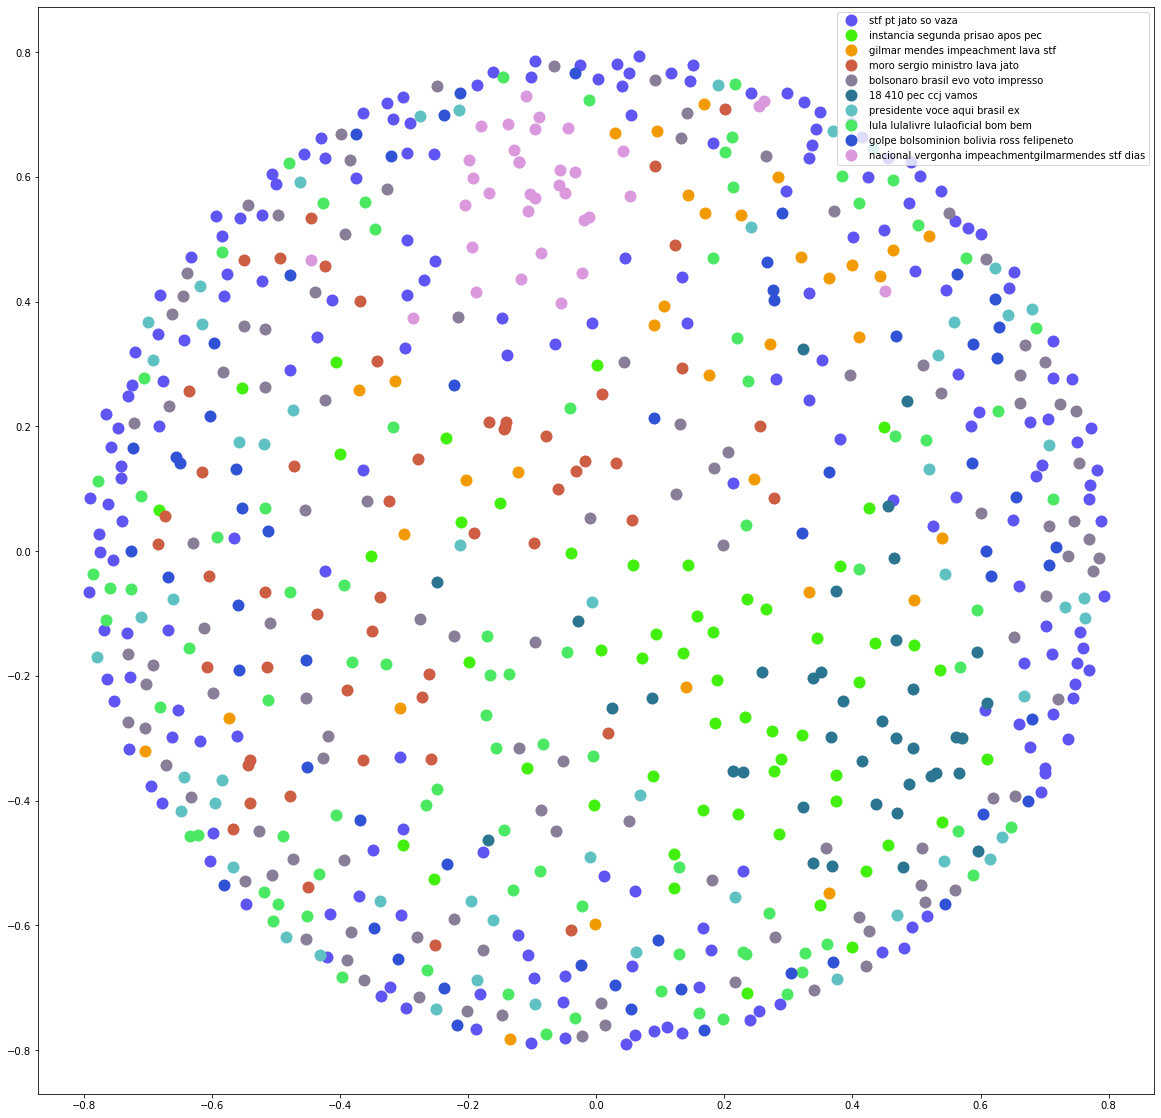

<Figure size 432x288 with 0 Axes>

In [35]:
title_df = [e[:3] for e in filtered_sentenses]
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=title_df)) 


groups = df.groupby('label') #agrupando elementos por label
fig, ax = plt.subplots(figsize=(20, 20)) 


for i, group in enumerate(groups):
    ax.plot(group[1].x, group[1].y, marker='o', linestyle='', ms=12, label=cluster_names[i], color=cluster_color[i], mec='none')

ax.legend(numpoints=1)  #show legend with only 1 point

plt.show()

plt.savefig(graphics_path+'cluster_{0}.png'.format(num_clusters), dpi=90)





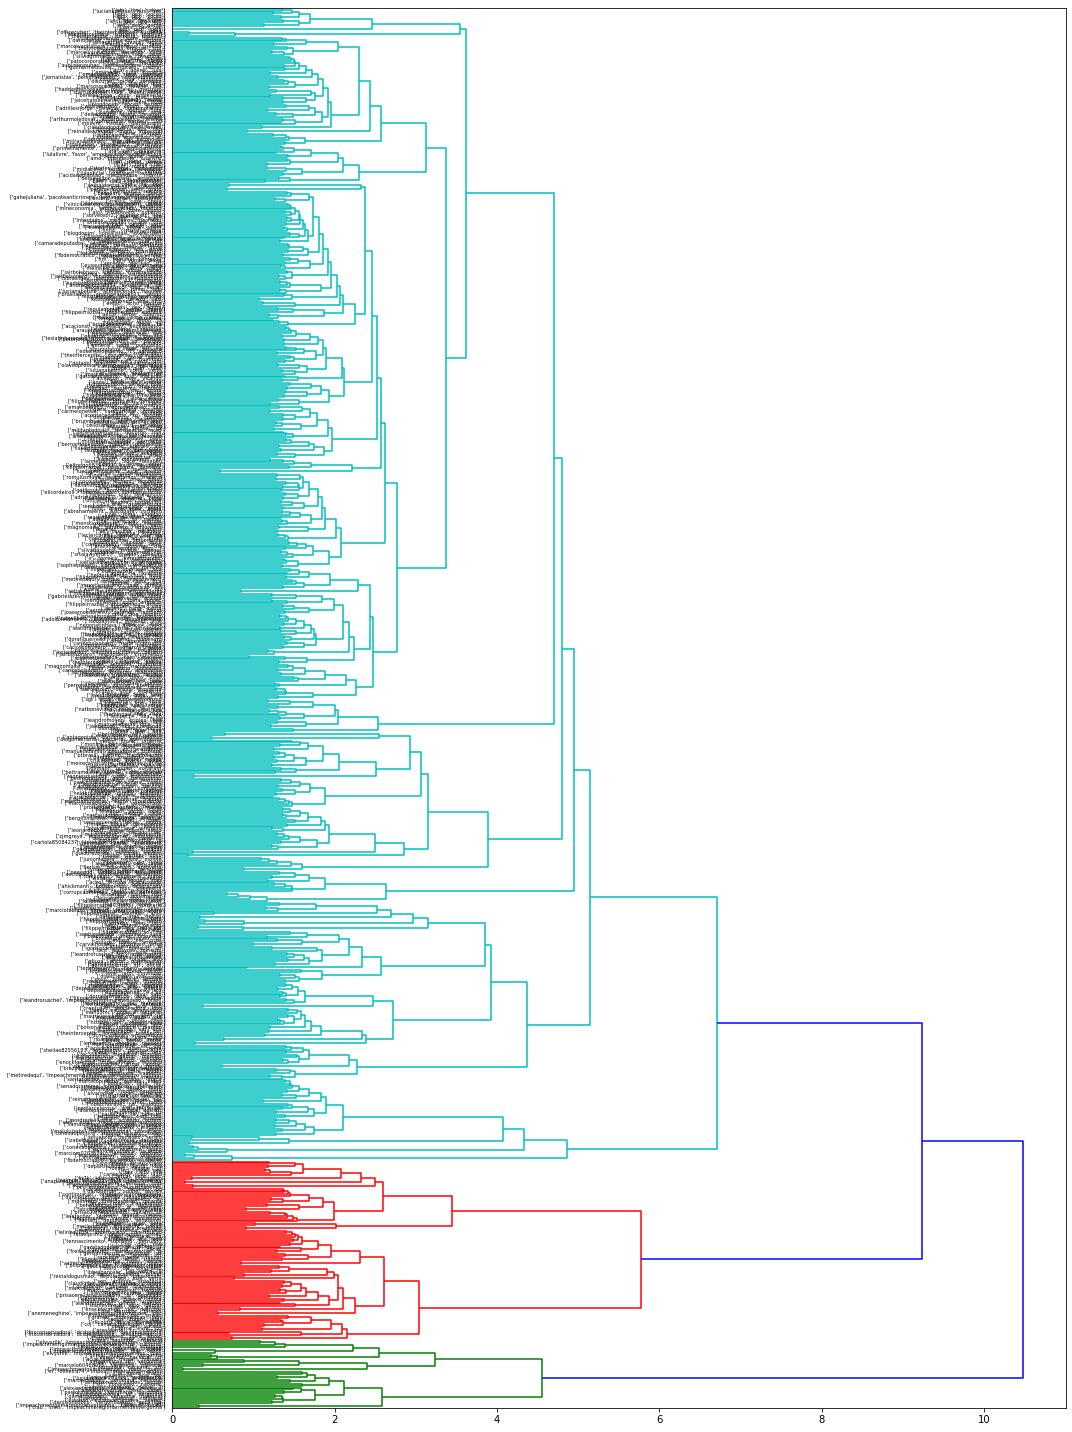

In [36]:



linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right", labels=title_df);

plt.tight_layout() #show plot with tight layout

plt.savefig(graphics_path+'demogram_c{0}.png'.format(num_clusters), dpi=200)
